Epoch 1/15
25/25 [==============================] - 9s 68ms/step - loss: 0.1582 - accuracy: 0.9422 - val_loss: 0.0178 - val_accuracy: 0.9982
Epoch 2/15
25/25 [==============================] - 1s 40ms/step - loss: 0.0073 - accuracy: 0.9984 - val_loss: 0.0046 - val_accuracy: 0.9987
Epoch 3/15
25/25 [==============================] - 1s 43ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.0031 - val_accuracy: 0.9991
Epoch 4/15
25/25 [==============================] - 1s 42ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0019 - val_accuracy: 0.9995
Epoch 5/15
25/25 [==============================] - 1s 43ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0015 - val_accuracy: 0.9996
Epoch 6/15
25/25 [==============================] - 1s 40ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0012 - val_accuracy: 0.9997
Epoch 7/15
25/25 [==============================] - 1s 43ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 9.5989e-04 - val_accuracy: 0.9998
Epoch 8/1

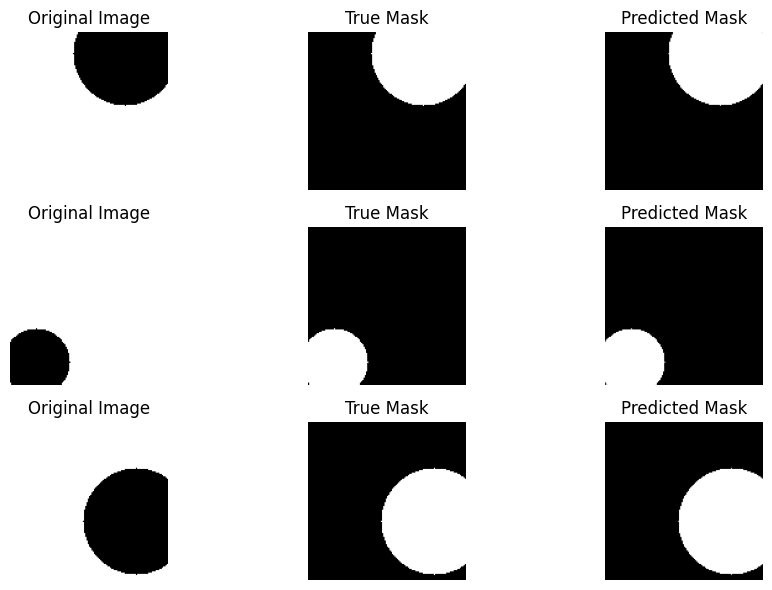

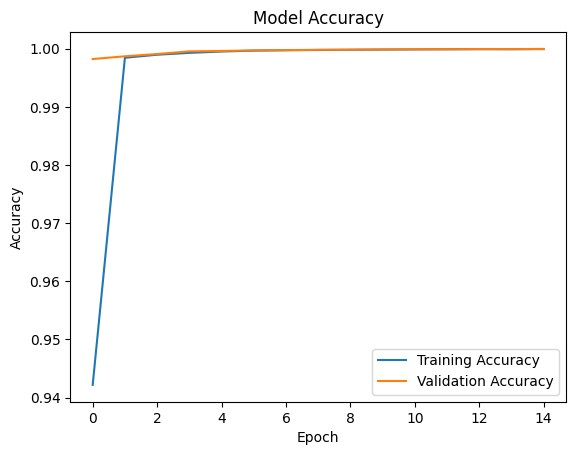

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam

# Dataset Preparation
def generate_data(image_size, shapes, num_images):
    X, y = [], []
    for _ in range(num_images):
        image = np.ones((image_size, image_size, 3), dtype=np.uint8) * 255  # White background
        mask = np.zeros((image_size, image_size), dtype=np.uint8)  # Black mask

        shape = np.random.choice(shapes)
        center = (np.random.randint(0, image_size), np.random.randint(0, image_size))

        if shape == 'circle':
            radius = np.random.randint(20, 50)
            cv2.circle(image, center, radius, (0, 0, 0), -1)
            cv2.circle(mask, center, radius, 1, -1)
        elif shape == 'rectangle':
            d = np.random.randint(20, 50)
            top_left = (max(center[0] - d, 0), max(center[1] - d, 0))
            bottom_right = (min(center[0] + d, image_size), min(center[1] + d, image_size))
            cv2.rectangle(image, top_left, bottom_right, (0, 0, 0), -1)
            cv2.rectangle(mask, top_left, bottom_right, 1, -1)
        elif shape == 'triangle':
            pts = np.array([[center, (center[0] + np.random.randint(-50, 50), center[1] + np.random.randint(-50, 50)),
                             (center[0] + np.random.randint(-50, 50), center[1] + np.random.randint(-50, 50))]])
            cv2.drawContours(image, [pts], 0, (0, 0, 0), -1)
            cv2.drawContours(mask, [pts], 0, 1, -1)

        X.append(image)
        y.append(mask)

    return np.array(X) / 255.0, np.array(y).reshape(-1, image_size, image_size, 1)

image_size = 128
num_images = 1000
shapes = ['circle', 'rectangle', 'triangle']
X, y = generate_data(image_size, shapes, num_images)

# Model Design
def build_model(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)

    # Decoder
    u1 = UpSampling2D((2, 2))(b)
    concat1 = concatenate([u1, c2])
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat1)
    u2 = UpSampling2D((2, 2))(c3)
    concat2 = concatenate([u2, c1])
    c4 = Conv2D(16, (3, 3), activation='relu', padding='same')(concat2)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = build_model()

# Training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=32)

# Inference and Evaluation
val_preds = model.predict(X_val)
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(X_val[i])
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(y_val[i].squeeze(), cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(val_preds[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Reporting key metrics
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
